### Imports, and Primary Set-Up

In [24]:
import requests
import json
import pandas as pd
from time import sleep

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Testing out the links:

In [415]:
cook = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cooking&size=100'
nut = 'https://api.pushshift.io/reddit/search/submission/?subreddit=nutrition&size=100'

res_cook = requests.get(cook)
sleep(1)
res_nut = requests.get(nut)

In [416]:
# making sure both urls are fine
print(res_cook.status_code)
print(res_nut.status_code)

200
200


In [417]:
# getting the dictionaries
cook_dict = res_cook.json()
nut_dict = res_nut.json()

In [418]:
# examining the dictionaries:
print(cook_dict.keys())
print(nut_dict.keys())

dict_keys(['data'])
dict_keys(['data'])


In [419]:
## Exploring the dictionaries: 
cook_dict['data'][0]
cook_dict['data'][0].keys()
len(cook_dict['data'])

100

In [420]:
cook_dict['data'][5]['selftext']

'Hello all,\n\nGrowing up in country NSW in a meat eating family I have not had a wide variety of fish in my life. I simply do not know what to experiment with. I have just learnt of the fish man who comes direct from the Sydney fish markets and am keen to try any suggestions! \n\nThank you in advance :)'

### Features and Target Variables
Posts (data) are in `cook_dict['data'][i]['selftext`], and target variable (class) is `cook_dict['data'][i]['subreddit']`

In [421]:
cook_data = []
cook_target = []
for i,_ in enumerate(cook_dict['data']):
    if cook_dict['data'][i]['selftext'] !='':
        cook_data.append(cook_dict['data'][i]['selftext'])
        cook_target.append(cook_dict['data'][i]['subreddit'])
cook = pd.DataFrame(zip(cook_data, cook_target), columns = ['post', 'topic'])

In [422]:
nut_target = []
for i,_ in enumerate(nut_dict['data']):
    if nut_dict['data'][i]['selftext']!='':
        nut_data.append(nut_dict['data'][i]['selftext'])
        nut_target.append(nut_dict['data'][i]['subreddit'])
nut = pd.DataFrame(zip(nut_data, nut_target), columns = ['post','topic'])

In [423]:
#merging the two dataframes together: 
df = pd.concat([cook, nut], axis = 0, sort = False)
df.shape

(188, 2)

In [424]:
# more cleaning, dropping rows with '[removed]' posts 
removed_posts_indices = df.loc[df['post']=='[removed]', :].index
df.drop(removed_posts_indices, inplace = True)

## Collecting a 100 posts from 60 days ago till now, in reverse order: 

In [425]:
base_url_cook = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cooking&size=100&before={}d'
urls_cook = [base_url_cook.format(i) for i in range(60,-1,-1)] # generate the urls
# the first -1 is the stopping point, coz range is exclusive to the endpoint. 
# the second -1 is to go in reverse on the range.
base_url_nut = 'https://api.pushshift.io/reddit/search/submission/?subreddit=nutrition&size=100&before={}d'
urls_nut = [base_url_nut.format(i) for i in range(60,-1,-1)]

In [426]:
pages_cook = []
for u in urls_cook:
    sleep(1)
    pages_cook.append(requests.get(u).json()['data'])

In [427]:
pages_nut = []
for u in urls_nut:
    sleep(1)
    pages_nut.append(requests.get(u).json()['data'])

In [428]:
cook_data = []
nut_data = []
cook_target = []
nut_target = []

for p in pages_cook: 
    for post in p:
        if post['selftext']!='':
            cook_data.append(post['selftext'])
            cook_target.append(post['subreddit'])

In [429]:
for p in pages_nut:
    count2 = 0
    for post in p:
        try: #because one post doesn't have a 'selftext'. nut_data stops at 116. therefore I need try/except
            if post['selftext']!='':
                nut_data.append(post['selftext'])
                nut_target.append(post['subreddit'])
        except: 
            nut_data.append('[removed]') # i want to add what I want to drop later on. some posts have '[removed]' in them
            nut_target.append('nutrition')

#### Making the each topic dataframe, then combining them into one dataframe

In [430]:
cook = pd.DataFrame(zip(cook_data, cook_target), columns = ['post', 'topic'])
cook.loc[cook['post']=='[removed]',:].index
cook.drop(cook.loc[cook['post']=='[removed]',:].index, inplace = True)

In [431]:
nut = pd.DataFrame(zip(nut_data, nut_target), columns = ['post', 'topic'])
nut.loc[nut['post']=='[removed]',:].index
nut.drop(nut.loc[nut['post']=='[removed]',:].index, inplace = True)

In [432]:
print(f'shape of the cleaned nutrition dataframe {nut.shape}')
print(f'shape of the cleaned cooking dataframe {cook.shape}')

shape of the cleaned nutrition dataframe (4166, 2)
shape of the cleaned cooking dataframe (4237, 2)


In [433]:
#combining the dataframes
df = pd.concat([cook, nut], axis = 0, sort = False)
# saving it to a csv file
df.to_csv('reddit_cook_nut.csv') 

#### Saving to csv file: 

In [25]:
df = pd.read_csv('reddit_cook_nut.csv') # so I don't have to request every time.
print(f'shape of the combined and ready dataframe {df.shape}')

shape of the combined and ready dataframe (8403, 3)


## EDA

In [8]:
df['topic'].value_counts() # nutrition class will be considered 1, and cooking 0

Cooking      4237
nutrition    4166
Name: topic, dtype: int64

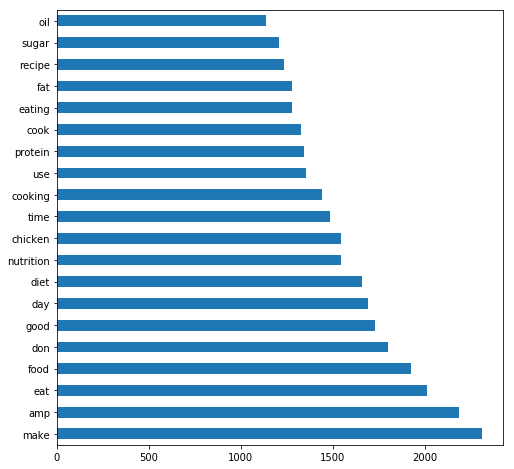

In [68]:
# plotting most repeated words, excluding non-relevant
import matplotlib.pyplot as plt
%matplotlib inline 

more_stop = ['just', 'com', 'https', 'know', 'want', 'www', 've','x200b', 'really', 'like'] 
custom_words = list(ENGLISH_STOP_WORDS) + more_stop

cv = CountVectorizer(stop_words = custom_words) # ngram_range = (1,2) means i want both 1 and 2 words columns
sparse_mat = cv.fit_transform(df['post']) #fitting the model

all_feature_df = pd.DataFrame(sparse_mat.todense(), columns=cv.get_feature_names()) #attaching column names ie. words

all_feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize = (8,8));
# remember, these are the lammatized words...

common_words_indicies = all_feature_df.sum().sort_values(ascending=False).head(20).index
# we need the indices because that's what .loc is looking for (or a boolean mask) when I use it below

### Most Frequent Words By Topic

In [55]:
# making a sparse matrix of the words
cv = CountVectorizer(stop_words = custom_words)
X_train_cv = cv.fit_transform(X_train) # this is the sparse matrix
# making this sparse matrix into a dataframe
sparse = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [56]:
sparse.shape

(6302, 17931)

In [57]:
df_nutrition = sparse.loc[df['topic'] == 'nutrition'].copy()
df_cooking = sparse.loc[df['topic'] == 'Cooking'].copy()

In [58]:
print(df_nutrition.shape, df_cooking.shape)

(2065, 17931) (4237, 17931)


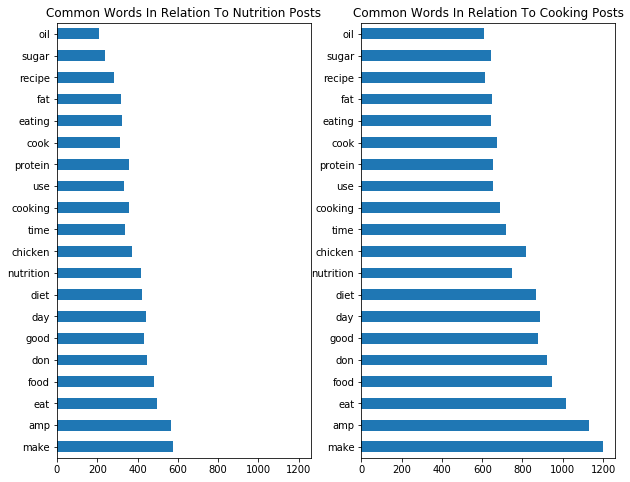

In [110]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8), sharex=True) #last argument to set same scale for x

df_nutrition.sum().loc[common_words_indicies].plot(kind = 'barh',
                                          ax = ax[0], title = 'common words in relation to Nutrition posts'.title());
df_cooking.sum().loc[common_words_indicies].plot(kind = 'barh', ax= ax[1], 
                                        title = 'common words in relation to cooking posts'.title());

## The Modeling:

In [9]:
# Train/test/split
X_train, X_test, y_train, y_test  = train_test_split(df['post'], df['topic'], 
                                                     stratify = df['topic'], random_state = 42)

### Creating models and Pipes & GridSearching on each & fitting & finding best score:

In [438]:
cv_log_pipe = Pipeline([('vector', CountVectorizer()), ('logreg', LogisticRegression())])
cv_log_params = {
    'vector__min_df' : [3,4,8],
    'vector__stop_words' : [custom_words, None],
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : [.1, 5, 50]
}
cv_log_gs = GridSearchCV(cv_log_pipe, cv_log_params, cv = 5, verbose=0)
cv_log_gs.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vector', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vector__min_df': [3, 4, 8], 'vector__stop_words': [['the', 'although', 'whereas', 'their', 'another', 'since', 'at', 'further', 'cant', 'too', 'via', 'what', 'being', 'ever', 'side', 'both', 'whence', 'yourself', 'whole', 'above', 'own', 'same', 'three', 'with', 'because', 'de', 'fifty'...'ve', 'x200b', 'really', 'like'], None], 'logreg__penalty': ['l1', 'l2'], 'logreg__C': [0.1, 5, 50]},
       pre_dispatch='2*n_jobs', refit

In [439]:
cv_nb_pipe = Pipeline([('vector', CountVectorizer()) , ('naive', MultinomialNB())])
cv_nb_params = {
    'vector__min_df' : [3,4,8],
    'vector__stop_words' : [custom_words, None],
    'naive__alpha' : [0.001, 0.01, 0.1, 0.5, 0.8]
}
cv_nb_gs = GridSearchCV(cv_nb_pipe, cv_nb_params, cv = 5, verbose=0)
cv_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vector', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocess...zer=None, vocabulary=None)), ('naive', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vector__min_df': [3, 4, 8], 'vector__stop_words': [['the', 'although', 'whereas', 'their', 'another', 'since', 'at', 'further', 'cant', 'too', 'via', 'what', 'being', 'ever', 'side', 'both', 'whence', 'yourself', 'whole', 'above', 'own', 'same', 'three', 'with', 'because', 'de', 'fifty'...want', 'www', 've', 'x200b', 'really', 'like'], None], 'naive__alpha': [0.001, 0.01, 0.1, 0.5, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
    

In [12]:
tf_log_pipe = Pipeline([('tfdf', TfidfVectorizer()),('logreg', LogisticRegression())])
tf_log_params = {
    'tfdf__stop_words' : [custom_words, None],
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : [.1, 5, 50]
}
tf_log_gs = GridSearchCV(tf_log_pipe, tf_log_params, cv = 5, verbose=0)
tf_log_gs.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfdf__stop_words': [['thereafter', 're', 'several', 'before', 'fifty', 'with', 'other', 'onto', 'thru', 'for', 'interest', 'rather', 'all', 'latter', 'part', 'whereby', 'thereupon', 'on', 'around', 'yours', 'since', 'mine', 'hereupon', 'ours', 'whole', 'almost', 'your', 'front', 'hasnt'...'ve', 'x200b', 'really', 'like'], None], 'logreg__penalty': ['l1', 'l2'], 'logreg__C': [0.1, 5, 50]},
       pre_dispatch='2*n_jobs', refit

In [13]:
tf_nb_pipe = Pipeline([('tfdf', TfidfVectorizer()),('naive', MultinomialNB())])
tf_nb_params = {
    'tfdf__stop_words' : [custom_words, None],
    'naive__alpha' : [0.001, 0.01, 0.1, 0.5, 0.8]
}
tf_nb_gs = GridSearchCV(tf_nb_pipe, tf_nb_params, cv = 5, verbose=0)
tf_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...e,
        vocabulary=None)), ('naive', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfdf__stop_words': [['thereafter', 're', 'several', 'before', 'fifty', 'with', 'other', 'onto', 'thru', 'for', 'interest', 'rather', 'all', 'latter', 'part', 'whereby', 'thereupon', 'on', 'around', 'yours', 'since', 'mine', 'hereupon', 'ours', 'whole', 'almost', 'your', 'front', 'hasnt'...want', 'www', 've', 'x200b', 'really', 'like'], None], 'naive__alpha': [0.001, 0.01, 0.1, 0.5, 0.8]},
       pre_dispatch='2*n_jobs', refit

In [14]:
## Random Forest Model
cv = CountVectorizer(stop_words = custom_words)
X_train_cv = cv.fit_transform(X_train)

In [450]:
forest = RandomForestClassifier()
forest_params = {
    'n_estimators' : [5, 10, 15, 20],
    'max_depth' : [10, 20, 30],
    'max_features' : [.2, .3]
}
gs_forest = GridSearchCV(forest, param_grid = forest_params, cv = 5)
gs_forest.fit(X_train_cv, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20], 'max_depth': [10, 20, 30], 'max_features': [0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### printing best scores of each model for comparison:

In [451]:
print('best score of random foresets is: ',gs_forest.best_score_.round(4))
print('best score of CountVectorizer with Logistic Regression is:', cv_log_gs.best_score_.round(4))
print('best score of CountVectorizer with naive multinomial Bayes is:', cv_nb_gs.best_score_.round(4))
print('best score of TFDIF with Logistic Regression is:', tf_log_gs.best_score_.round(4))
print('best score of TFDIF with naive multinomial Bayes is:', tf_nb_gs.best_score_.round(4))

best score of random foresets is:  0.9129
best score of CountVectorizer with Logistic Regression is: 0.9586
best score of CountVectorizer with naive multinomial Bayes is: 0.946
best score of TFDIF with Logistic Regression is: 0.9694
best score of TFDIF with naive multinomial Bayes is: 0.9606


In [23]:
## the winner is TFDIF with Logistic Regression, so we're gonna fit that one
# fininding best estimators of the winning model to use them: 
print(tf_log_gs.best_estimator_.get_params()['steps'])

[('tfdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['thereafter', 're', 'several', 'before', 'fifty', 'with', 'other', 'onto', 'thru', 'for', 'interest', 'rather', 'all', 'latter', 'part', 'whereby', 'thereupon', 'on', 'around', 'yours', 'since', 'mine', 'hereupon', 'ours', 'whole', 'almost', 'your', 'front', 'hasnt', 'them', 'together', ...'to', 'any', 'down', 'just', 'com', 'https', 'know', 'want', 'www', 've', 'x200b', 'really', 'like'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('logreg', LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='

#### fitting the winning model and vectorizer:

In [454]:
tf = TfidfVectorizer(stop_words = custom_words)

X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)
print(X_train_tf.shape)

(6302, 17931)


In [455]:
logreg = LogisticRegression(C = 50, penalty = 'l2') #l2 is Ridge (google: 'l1 ridge or lasso?')
logreg.fit(X_train_tf, y_train)
preds = logreg.predict(X_test_tf)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [456]:
print('accuracy score of TFDIF and Logistic on testing data: ', logreg.score(X_test_tf, y_test).round(4))
print('cross-validation score is: ', \
    cross_val_score(logreg, X_train_tf, y_train, cv = 5).mean().round(4)) 
#this cross-val score is how we expect the model to perform on unseen data

accuracy score of TFDIF and Logistic on testing data:  0.9805


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cross-validation score is:  0.9689


In [523]:
# extra making sure it's not overfitting, by scoring it on train and test dataset
print('on training set, score is: ', tf_log_gs.score(X_train, y_train).round(4))
print('on testing set, score is: ', tf_log_gs.score(X_test, y_test).round(4))

on training set, score is:  0.999
on testing set, score is:  0.9805


### getting confusion matrix & classification report

In [457]:
confusion_matrix(y_test, preds)
print('classification report', classification_report(y_test, preds))

classification report               precision    recall  f1-score   support

     Cooking       0.99      0.97      0.98      1059
   nutrition       0.97      0.99      0.98      1042

   micro avg       0.98      0.98      0.98      2101
   macro avg       0.98      0.98      0.98      2101
weighted avg       0.98      0.98      0.98      2101



In [458]:
# to make confusion matrix look nicer: 
col_names = ['Predicted ' + i for i in df['topic'].value_counts().index]
index_names = ['Actual ' + i for i in df['topic'].value_counts().index]
cm = pd.DataFrame(confusion_matrix(y_test, preds), columns = col_names, index = index_names )
cm

,Predicted Cooking,Predicted nutrition
Actual Cooking,1029,30
Actual nutrition,11,1031


### getting coefficients of the winning model and plotting them:

In [459]:
tf_log_gs.best_estimator_.steps[1][1].coef_ # same as logreg.coef_ 

array([[-1.15855269e-01,  8.34834760e-01, -4.35515088e-02, ...,
         1.42242828e-06, -7.21437624e-04, -1.73116669e-04]])

In [460]:
# making coeficients into a dataframe to plot them
coef_df = pd.DataFrame(logreg.coef_, columns = tf.get_feature_names()).T.sort_values(by = 0).head(15)
coef_df['abs'] = coef_df[0].abs()
coef_df.sort_values(by = 'abs', ascending = False).head(15)

,0,abs
cooking,-11.332207,11.332207
recipe,-10.476970,10.476970
recipes,-9.701914,9.701914
make,-8.160371,8.160371
dish,-7.683484,7.683484
making,-7.438412,7.438412
imgur,-6.572811,6.572811
use,-6.431580,6.431580
ideas,-6.352363,6.352363
delicious,-5.801782,5.801782


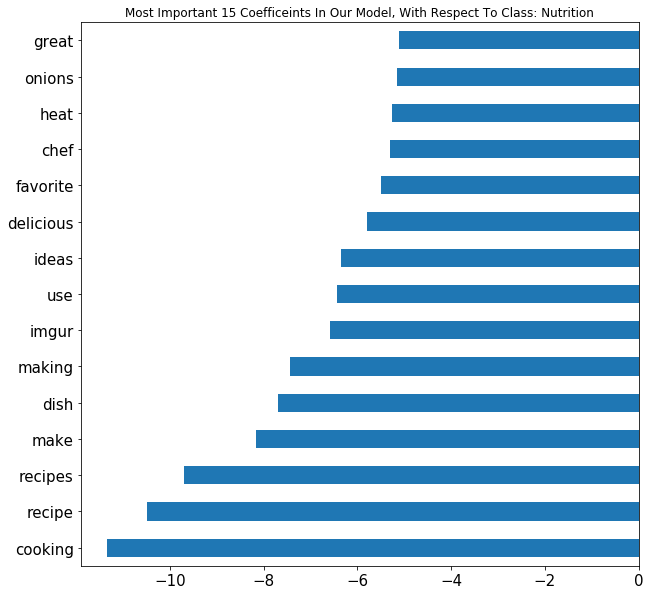

In [461]:
# plotting most important coefficients: 
coef_df.sort_values(by = 'abs', ascending = False).head(15)[0].plot(kind = 'barh', figsize = (10,10), title = "most \
important 15 coefficeints in our model, with respect to class: nutrition".title(), fontsize = 15);

## Extra Exploration, Tweaking, and Evaluation

As it is, predict_proba has a threshold of 0.5, anything >=0.5 is classified in the positive class/the one class (here, nutrition, and anything less is classified in the negative class/the zero class (here, cooking). <br /> 
Say I wanted to minimize false positives (top right corner in the confusion matrix), to reduce number of 
cooking posts that get classified as nutrition. To do that, I would need to increase the threshold. <br /> A high false positives number means it's classifying more as positives. Therefore, to lower the FP, we need to increase the threshold. <br /> Doing this, I'm saying: don't flag more cooking posts as nutrition. <br /> we need to do that manually. 

In [505]:
# getting prediction probabilities from our winning model, only for the positive class 
probs_nut = tf_log_gs.predict_proba(X_test)[:,1]

In [507]:
# setting the threshold, and getting the new predictions/classifications: 
def classify(thresh, probs_list):
    """
    thresh: threshold of classification 
    probs_list: a list of predict_proba of only the class of interest. Must be worked outside the function 
    """
    preds_thresh = ['nutrition' if probs_list[i] >= thresh else 'Cooking' for i in range(len(probs_list))]
    return preds_thresh

In [510]:
# getting the confusion matrix with the new threshold predictions:  
pd.DataFrame(confusion_matrix(y_test, classify(0.9, probs_nut)), columns = col_names, index = index_names )
# col_names, and index_names are defined above

,Predicted Cooking,Predicted nutrition
Actual Cooking,1049,10
Actual nutrition,66,976


In [511]:
# seeing the new classification report to check for precision: 
print(classification_report(y_test, classify(0.9, probs_nut)))

              precision    recall  f1-score   support

     Cooking       0.94      0.99      0.97      1059
   nutrition       0.99      0.94      0.96      1042

   micro avg       0.96      0.96      0.96      2101
   macro avg       0.97      0.96      0.96      2101
weighted avg       0.97      0.96      0.96      2101



We gained improvement in precision, but this means our flase negatives are higher (these are nutrition posts that are being classified as cooking). So if you're interested in reading almost every nutrition post, this is not helpful to you. 

#### Finally visualizing our model performance using a ROC curve

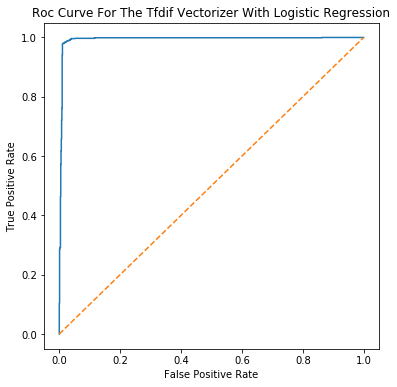

In [524]:
# Drawing the ROC curve to visually evaluate our model
from sklearn.metrics import roc_curve

# to set up for ROC curve 
y_numerical = y_test.map({'nutrition' : 1 , 'Cooking' : 0})
fpr, tpr, _ = roc_curve(y_numerical, probs_nut)

plt.figure(figsize = (6,6))
plt.plot(fpr, tpr);
plt.plot([0,max(y_numerical)],[0, max(y_numerical)], '--'); # it takes only encoded numerical y
plt.title('ROC curve for the TFDIF vectorizer with logistic regression'.title());
plt.xlabel('false positive rate'.title());
plt.ylabel('true positive rate'.title());

## For a mere visual appeal,
Creating an image of the most common words

In [66]:
import wordcloud

In [90]:
common_words = all_feature_df.sum().sort_values(ascending=False).head(20) # this is a series of words and their count
list(common_words.index)
common_words = ' '.join(list(common_words.index))

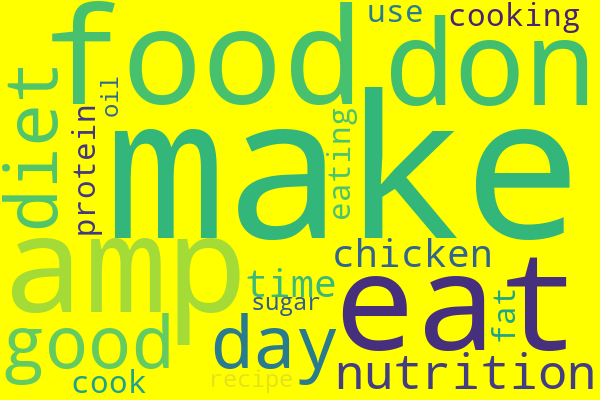

In [107]:
wc = wordcloud.WordCloud(background_color='yellow', max_words=75, width=600, height =400)
# adding stop words will put only the stop words, not eliminate them.
cloud = wc.generate(common_words)
cloud.to_image()